In [8]:
pip install scikit-uplift

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklift.metrics import qini_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklift.models import SoloModel

In [10]:
# Load balanced dataset

path = "/Users/rohityadav/Desktop/Git Projects/ml-uplift-modeling-criteo/data/criteo-uplift-v2.1-100K-balanced.csv"
df = pd.read_csv(path)

# Define X,Y and T

X = df.drop(['treatment', 'visit', 'exposure', 'conversion'], axis = 1)
Y = df['visit'].astype(int)
T = df['treatment'].astype(int)

# Train/Test Split 

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y,
    test_size = 0.3,
    stratify = T,
    random_state = 42
)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('Treatment ratio train:', T_train.mean())
print('Treatment ratio test:', T_test.mean())

X_train shape: (70000, 12)
X_test shape: (30000, 12)
Treatment ratio train: 0.5
Treatment ratio test: 0.5


In [12]:
# Basline Uplift scores (T-learner)

# Train two different models - Treated and Control

model_treated = LogisticRegression(max_iter = 2000)
model_control = LogisticRegression(max_iter = 2000)

model_treated.fit(X_train[T_train == 1], Y_train[T_train == 1])
model_control.fit(X_train[T_train == 0], Y_train[T_train == 0])

# Predict on test
p_treated = model_treated.predict_proba(X_test)[:, 1]
p_control = model_control.predict_proba(X_test)[:, 1]

uplift_tlearner = p_treated - p_control

In [14]:
# Uplift RF

uplift_rf = SoloModel(RandomForestClassifier(
    n_estimators = 100,
    max_depth = 6,
    min_samples_leaf = 200,
    random_state = 42
))

uplift_rf.fit(X_train, Y_train, T_train)
uplift_rf_scores = uplift_rf.predict(X_test)

In [15]:
# AUUC computation

auuc_t = qini_auc_score(Y_test, uplift_tlearner, T_test)
auuc_rf = qini_auc_score(Y_test, uplift_rf_scores, T_test)

print('AUUC T-learner Basline:', auuc_t)
print('AUUC Uplift Random Forest:', auuc_rf)

AUUC T-learner Basline: 0.1344967647498336
AUUC Uplift Random Forest: 0.09835518176853725


In [22]:
# Manual QINI curve

def compute_qini_curve(y, uplift, treatment):
    order = np.argsort(-uplift)

    y = y.iloc[order].to_numpy()
    t = treatment.iloc[order].to_numpy()

    cum_treated = np.cumsum(t)
    cum_control = np.cumsum(1-t)

    cum_y_treated = np.cumsum(y * t)
    cum_y_control = np.cumsum(y * (1 - t))

    treated_rate = np.divide(
        cum_y_treated, cum_treated,
        out = np.zeros_like(cum_y_treated, dtype = float),
        where = cum_treated > 0
    )

    control_rate = np.divide(
        cum_y_control, cum_control,
        out = np.zeros_like(cum_y_control, dtype = float),
        where = cum_control > 0
    )

    qini = treated_rate - control_rate
    fraction = np.arange(1, len(qini) + 1)/len(qini)

    return fraction, qini

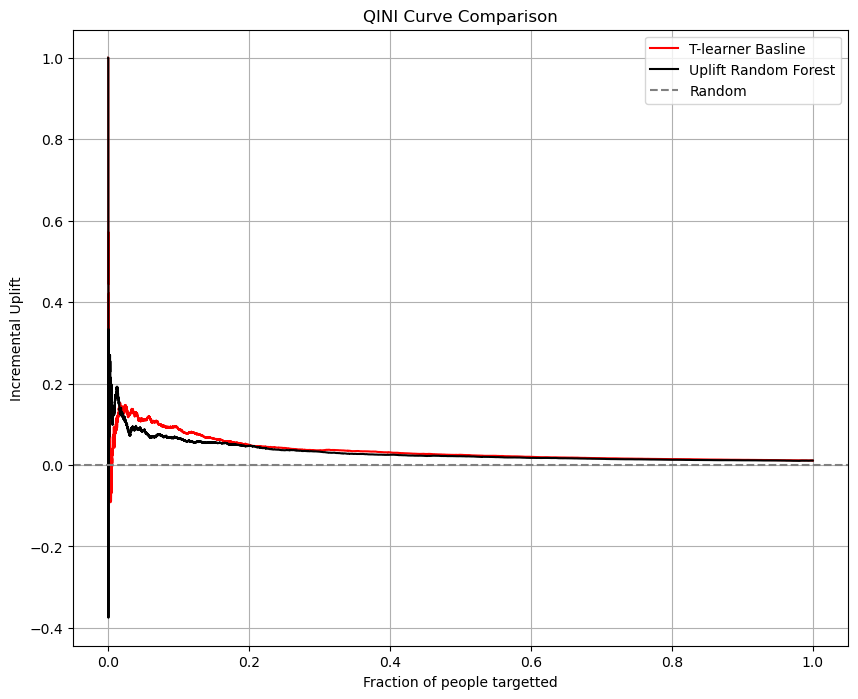

In [30]:
# Plot QINI curves

import matplotlib.pyplot as plt

frac_t, qini_t = compute_qini_curve(Y_test, uplift_tlearner, T_test)
frac_rf, qini_rf = compute_qini_curve(Y_test, uplift_rf_scores, T_test)

plt.figure(figsize = (10, 8))
plt.plot(frac_t, qini_t, label = 'T-learner Basline', color = 'red')
plt.plot(frac_rf, qini_rf, label  = 'Uplift Random Forest', color = 'black')
plt.axhline(0, linestyle = '--', color = 'gray', label = 'Random')

plt.xlabel('Fraction of people targetted')
plt.ylabel('Incremental Uplift')
plt.title('QINI Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

**What do I learn from this graph?**

On this dataset, the two-model T-learner achieved a higher AUUC than the uplift random forest. This is likely because the underlying features are highly predictive of the outcome, making separate response models very effective. The uplift random forest produced smoother and more conservative uplift estimates, trading early ranking performance for stability.

**Explanation in the easiest words:**

Most users are only slightly affected by ads, but a small subset responds strongly. The value comes from targeting that subset, not from raising the average for everyone.